In [31]:
using Pkg
Pkg.activate("../..")

  Activating project at `c:\Users\ladis\GitHub\SparseSpikes`


In [32]:
using Plots, LinearAlgebra, LaTeXStrings, Random
using FFTW: fft, fftshift
using SparseSpikes

Define ground truth amplitudes and positions

In [33]:
domain  = [[0, 1], [0, 1]]

x₀ = [[0.1, 0.2, 0.7],[0.5, 0.4, 0.8]]
a₀ = [2.0, -1.0, 1.5]

μ₀ = DiscreteMeasure(x₀, a₀)

DiscreteMeasure{Float64}([[0.1, 0.2, 0.7], [0.5, 0.4, 0.8]], [2.0, -1.0, 1.5], 2, 3)

In [34]:
# Define the number of Fourier coefficients
fc = 6
n = 2fc + 1

# Define noise level
noise_level = 0.1

# Seed for noise
Random.seed!(22)

TaskLocalRNG()

In [35]:
n_coarse_grid = 20
n_plt_grid = 100

coarse_grids = build_grid(domain, n_coarse_grid)
plt_grids = build_grid(domain, n_plt_grid)
hm_grid = build_grid(domain[1, :], n_plt_grid)

plot_size = (400, 400) .* 1
plt = heatmap(xlims=domain[1], ylims=domain[2], color=:viridis, size=plot_size, grid=false);

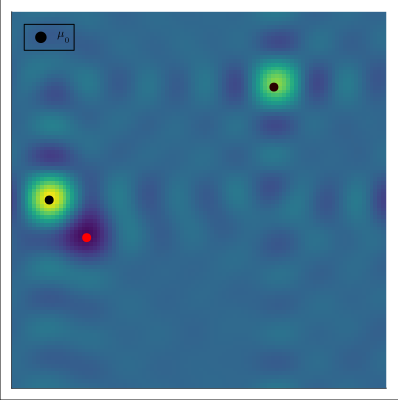

In [36]:
ops = fourier_operators_2D(fc, plt_grids)

y₀ = ops.Φₓ(μ₀...)

# Add noise to the observation y = y₀ + ϵ
sigma = noise_level * norm(y₀)
ϵ = fftshift(fft(randn(length(y₀))))
ϵ = ϵ / norm(ϵ) * sigma
y = y₀ + ϵ

plt_obs = deepcopy(plt)

heatmap!(plt_obs, hm_grid, hm_grid, ops.Φₓᴴ(y)', color=:viridis)
plot_spikes!(plt_obs, μ₀, label=L"μ_0", colorscheme=get_cmap(:red_black))

## Pre-certificate

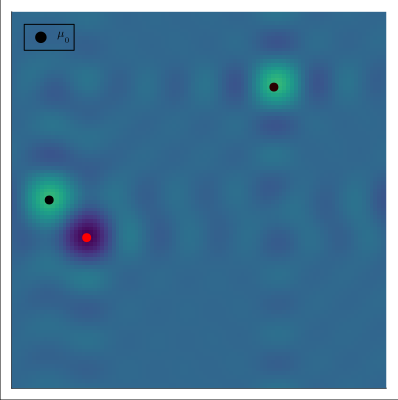

In [37]:
ηᵥ = ops.ηᵥ(μ₀...)

plt_cert = deepcopy(plt)

heatmap!(plt_cert, hm_grid, hm_grid, ηᵥ(plt_grids)', color=:viridis)
plot_spikes!(plt_cert, μ₀, label=L"μ_0", colorscheme=get_cmap(:red_black))

### SFW

In [38]:
coarse_grid = build_grid(domain, n_coarse_grid)
λ_max = λ₀(coarse_grid, ops.ϕ, y, 1e-2)
println("Largest λ is $(round(λ_max, digits=3)).")

In [39]:
λ = 0.09

prob = BLASSO(y, ops, domain, n_coarse_grid, λ=λ)

Largest λ is 1.979.


BLASSO(ComplexF64[0.04399068253756631 + 0.015300356982593844im, -0.0932480790086804 - 0.04230199086180349im, -0.28173118710917605 + 0.04628214976680034im, -0.035912713177379325 - 0.07279181642645596im, 0.054311399322519036 - 0.3530062037994785im, 0.07891000713288149 - 0.1329645911391206im, 0.2629953869489766 + 0.1437537774273463im, 0.18076295982719798 + 0.08164127584843486im, -0.1180858762633669 + 0.11907843201238im, -0.10615096712559441 + 0.19582212788595932im  …  -0.10615096712559441 - 0.19582212788595932im, -0.1180858762633669 - 0.11907843201238im, 0.18076295982719798 - 0.08164127584843486im, 0.2629953869489766 - 0.1437537774273463im, 0.07891000713288149 + 0.1329645911391206im, 0.054311399322519036 + 0.3530062037994785im, -0.035912713177379325 + 0.07279181642645595im, -0.28173118710917605 - 0.04628214976680034im, -0.0932480790086804 + 0.04230199086180349im, 0.043990682537566314 - 0.015300356982593844im], Operators(SparseSpikes.var"#ϕ!#fourier_operators_2D##4"{Float64, Float64, Int64

In [40]:
prob_sfw = deepcopy(prob)

solve!(prob_sfw, options = Dict(:maxits => 4))

SFW iterations:  2    Time: 0:00:01

BLASSO(ComplexF64[0.04399068253756631 + 0.015300356982593844im, -0.0932480790086804 - 0.04230199086180349im, -0.28173118710917605 + 0.04628214976680034im, -0.035912713177379325 - 0.07279181642645596im, 0.054311399322519036 - 0.3530062037994785im, 0.07891000713288149 - 0.1329645911391206im, 0.2629953869489766 + 0.1437537774273463im, 0.18076295982719798 + 0.08164127584843486im, -0.1180858762633669 + 0.11907843201238im, -0.10615096712559441 + 0.19582212788595932im  …  -0.10615096712559441 - 0.19582212788595932im, -0.1180858762633669 - 0.11907843201238im, 0.18076295982719798 - 0.08164127584843486im, 0.2629953869489766 - 0.1437537774273463im, 0.07891000713288149 + 0.1329645911391206im, 0.054311399322519036 + 0.3530062037994785im, -0.035912713177379325 + 0.07279181642645595im, -0.28173118710917605 - 0.04628214976680034im, -0.0932480790086804 + 0.04230199086180349im, 0.043990682537566314 - 0.015300356982593844im], Operators(SparseSpikes.var"#ϕ!#fourier_operators_2D##4"{Float64, Float64, Int64

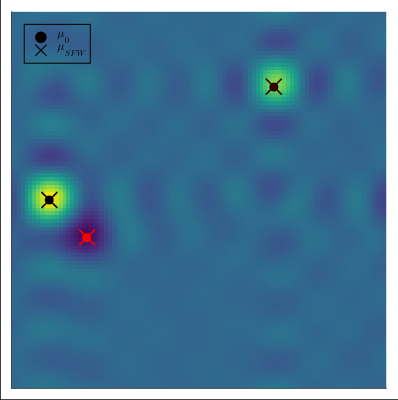

In [41]:
plt_sfw = deepcopy(plt_obs)

plot_spikes!(plt_sfw, prob_sfw.μ, label=L"μ_{SFW}", colorscheme=get_cmap(:red_black), marker=:x, markersize=8, markerstrokewidth=2)

## Plot $\eta_\lambda$

0.9999352491107085

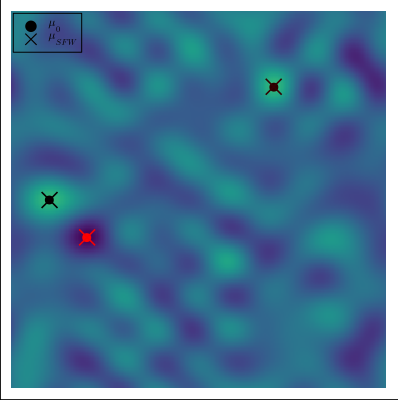

In [44]:
using Plots.Measures
n_fine_plt_grid = 300

fine_plt_grids = build_grid(domain, n_fine_plt_grid)
fine_hm_grid = build_grid(domain[1,:], n_fine_plt_grid)
display(maximum(prob_sfw.η(fine_plt_grids)))
heatmap(fine_hm_grid, fine_hm_grid, prob_sfw.η(fine_plt_grids)', color=:viridis, grid=false, ticks=:none, cb=false, size=plot_size, margins=-2mm)
plot_spikes!(μ₀, label=L"μ_0", markersize=5, colorscheme=get_cmap(:red_black))
plot_spikes!(prob_sfw.μ, label=L"μ_{SFW}", colorscheme=get_cmap(:red_black), marker=:x, markersize=8, markerstrokewidth=2)